# Capturing greenhouse gases with data

## Model Development

### by Zachary Brown

Now that my dataset has been cleaned, explored, and preprocessed, it's time to begin testing a range of models to determine which can best predict the volumetric CO2 working capacity and then explore which features boost that capacity the most.

I'll start by installing the necessary libraries and then importing everything we'll need.

In [1]:
!pip install xgboost==1.7.4
!pip install lightgbm==3.3.5

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
from matplotlib import rcParams

In [2]:
sns.set_theme('notebook')
rcParams['mathtext.default'] = 'regular'

Let's start by importing the training data.

In [58]:
X_train = pd.read_csv('../data/processed/X_train.csv', index_col = 'filename')
y_train = pd.read_csv('../data/processed/y_train.csv', index_col = 0)

In [59]:
X_train.head()

,unit_cell_volume,Density,accessible_surface_area,volumetric_surface_area,gravimetric_surface_area,accessible_volume_per_uc,volume_fraction,grav_volume,probe_occupiable_vol,probe_occ_vol_frac,...,lc-S-0-all,lc-S-1-all,lc-S-2-all,lc-S-3-all,lc-alpha-0-all,lc-alpha-1-all,lc-alpha-2-all,lc-alpha-3-all,D_lc-chi-2-all,D_lc-S-2-all
filename,,,,,,,,,,,,,,,,,,,,,
DB0-m3_o25_o84_f0_fsc.sym.10.cif,1143.94,1.003360,207.585,1814.65,1808.58,137.9590,0.12060,0.120196,520.493,0.4550,...,0.547700,0.569800,0.83625,1.428350,41.425,71.755000,85.800000,185.320000,0.690,-0.030000
DB0-m2_o26_o27_f0_pcu.sym.20.cif,5289.09,0.330792,845.532,1598.63,4832.75,3122.8900,0.59044,1.784930,4432.260,0.8380,...,0.542767,0.759733,1.30000,1.126967,36.980,95.673333,136.635076,129.961743,1.480,0.213333
DB0-m3_o23_o23_f0_nbo.sym.54.cif,16203.70,0.208859,2160.230,1333.17,6383.11,11222.0000,0.69256,3.315920,13627.300,0.8410,...,0.532900,0.562100,1.09500,0.562100,28.090,59.890000,87.980000,59.890000,0.890,-0.040000
DB0-m3_o1_o146_f0_fsc.sym.37.cif,1661.86,0.944809,178.499,1074.10,1136.84,69.6984,0.04194,0.044390,465.320,0.2800,...,0.547700,0.858550,1.40250,1.120850,41.425,113.565000,160.962614,120.622614,1.775,0.340000
DB0-m29_o89_o500_f0_pts.sym.68.cif,1886.38,0.849738,290.885,1542.03,1814.71,200.5980,0.10634,0.125145,821.519,0.4355,...,0.532900,0.562100,1.09500,1.124200,28.090,59.890000,87.980000,119.780000,0.890,-0.040000


In [60]:
y_train.head()

,0
0,82.851179
1,1.141462
2,0.623254
3,32.874921
4,20.352463


Now I want to perform an initial train/test split using just 10% of this data to train initial models so I can get a quick feel for how well each model will perform.

In [61]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.9, random_state=15)

In [62]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((20475, 450), (184275, 450), (20475, 1), (184275, 1))

In [63]:
# Reshape y_train for model fitting
y_tr = y_tr.values.ravel()
y_te = y_te.values.ravel()

In [64]:
y_tr.shape, y_te.shape

((20475,), (184275,))

I'm going to replace some characters that may be in the datasets so they don't cause errors with XGBoost.

In [65]:
X_tr.columns = X_tr.columns.str.replace('[', '_')
X_tr.columns = X_tr.columns.str.replace(']', '_')
X_tr.columns = X_tr.columns.str.replace(' ', '_')
X_tr.columns = X_tr.columns.str.replace(',', '_')
X_te.columns = X_te.columns.str.replace('[', '_')
X_te.columns = X_te.columns.str.replace(']', '_')
X_te.columns = X_te.columns.str.replace(' ', '_')
X_te.columns = X_te.columns.str.replace(',', '_')

C:\Users\zbro1\AppData\Local\Temp\ipykernel_11644\4225583205.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tr.columns = X_tr.columns.str.replace('[', '_')
C:\Users\zbro1\AppData\Local\Temp\ipykernel_11644\4225583205.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tr.columns = X_tr.columns.str.replace(']', '_')
C:\Users\zbro1\AppData\Local\Temp\ipykernel_11644\4225583205.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_te.columns = X_te.columns.str.replace('[', '_')
C:\Users\zbro1\AppData\Local\Temp\ipy

Now I'm ready to start making some models. I'll begin with dummy models using mean and median to set a baseline to determine whether the other models are any good at all. I'll also build a dataframe called train_scores to keep track of the model scores so I can plot my progress as I go. 

In [110]:
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_tr, y_tr)
y_pred = dummy_mean.predict(X_te)
train_scores = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Mean Dummy Regressor', '% Train Data' : 10,\
                              'RMSE' : mean_squared_error(y_te, y_pred)}])
print(mean_squared_error(y_te, y_pred))

408.04907666419814


In [111]:
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(X_tr, y_tr)
y_pred = dummy_median.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Median Dummy Regressor', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

478.3062211582237


Now I'll start with an OLS regressor, then ridge and lasso.

In [113]:
ols = LinearRegression()
ols.fit(X_tr, y_tr)
y_pred = ols.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'OLS', '% Train Data' : 10, 'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

405.45832716213954


For the rest of the models I'm exploring I'll need to do some hyperparameter tuning. Before spending that much time on tuning I'll create a model of each using the default parameters just to see how they score.

In [115]:
ridge=Ridge(random_state = 15)
ridge.fit(X_tr, y_tr)
y_pred = ridge.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Ridge Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

488.86755363408946


In [117]:
lasso=linear_model.Lasso(random_state = 15)
lasso.fit(X_tr, y_tr)
y_pred = lasso.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Lasso Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te, y_pred))

651.8153922270997


C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.349e+05, tolerance: 8.481e+02
  model = cd_fast.enet_coordinate_descent(


In [119]:
forest = RandomForestRegressor(max_depth=10, n_jobs = -1, random_state=15)
forest.fit(X_tr, y_tr)
y_pred = forest.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Random Forest Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

9.202145352744651

In [121]:
xgb = XGBRegressor(max_depth=10, seed=15)
xgb.fit(X_tr, y_tr)
y_pred = xgb.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'XGBoost Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

8.593579805487447

In [122]:
xgb_linear = XGBRegressor(booster = 'gblinear', seed=15)
xgb_linear.fit(X_tr, y_tr)
y_pred = xgb_linear.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'XGBoost Linear Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

516.119624581127

In [123]:
xgb_linear_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', seed=15)
xgb_linear_lcd.fit(X_tr, y_tr)
y_pred = xgb_linear_lcd.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'XGBoost Linear Coord Desc Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

514.7229276670863

In [124]:
dtree = tree.DecisionTreeRegressor(max_depth = 10, random_state = 15)
dtree.fit(X_tr, y_tr)
y_pred = dtree.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Decision Tree Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

16.987966030357054

In [125]:
knn = KNeighborsRegressor(n_jobs = -1)
knn.fit(X_tr, y_tr)
y_pred = knn.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'KNN Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

19.887800455841536

In [126]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'rmse', max_depth = 10, data_random_seed = 15)
lgbm.fit(X_tr, y_tr)
y_pred = lgbm.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 1, 'Model' : 'Light GBM Default', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

7.116764742236408

Now I'm going to plot these default model scores with 10% training data to see how they compare against one another. For reference the dummy models were in the 400s.

In [127]:
defaults = train_scores[['Default' in x for x in train_scores['Model'].unique()]]

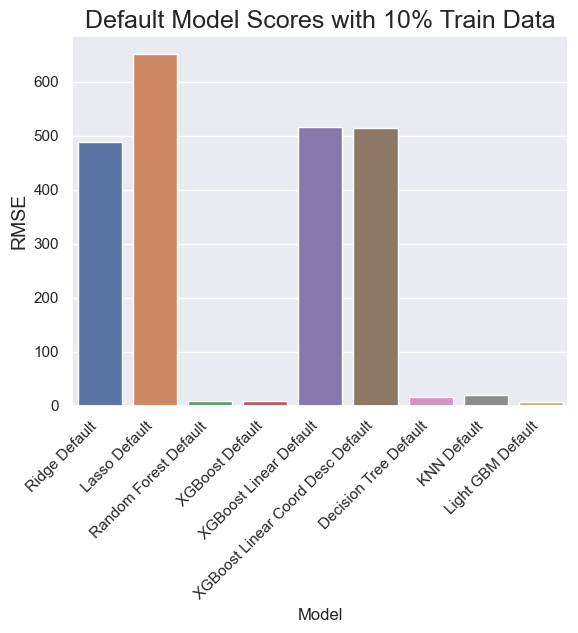

In [128]:
sns.barplot(data=defaults, x='Model', y='RMSE')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('')
plt.title('Default Model Scores with 10% Train Data', fontsize = 18)
plt.xticks(rotation=45, ha='right')
plt.savefig('../figures/default_10_models.png',dpi=1200, bbox_inches='tight')
plt.show()

Next, to confirm that those with the lowest scores are truly the best, I'll prepare an 80% training data split and make a fresh set of default models, but this time trained with 8 times more data. 

In [129]:
# Train/test split with new variables for the 80% train splits
X_tr8, X_te8, y_tr8, y_te8 = train_test_split(X_train, y_train, test_size=0.2, random_state=15)

In [130]:
y_tr8 = y_tr8.values.ravel()
y_te8 = y_te8.values.ravel()

In [131]:
dummy_mean = DummyRegressor(strategy="mean")
dummy_mean.fit(X_tr8, y_tr8)
y_pred = dummy_mean.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Mean Dummy Regressor', '% Train Data' : 80,\
                              'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te8, y_pred))

407.8835873965248


In [132]:
dummy_median = DummyRegressor(strategy="median")
dummy_median.fit(X_tr8, y_tr8)
y_pred = dummy_median.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Median Dummy Regressor', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te8, y_pred))

481.42949851544324


In [133]:
ols = LinearRegression()
ols.fit(X_tr8, y_tr8)
y_pred = ols.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'OLS', '% Train Data' : 80, 'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te8, y_pred))

584.8471427442527


In [134]:
ridge=Ridge(random_state = 15)
ridge.fit(X_tr8, y_tr8)
y_pred = ridge.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Ridge Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te8, y_pred))

714.6498490983072


In [135]:
lasso=linear_model.Lasso(random_state = 15)
lasso.fit(X_tr8, y_tr8)
y_pred = lasso.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Lasso Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
print(mean_squared_error(y_te8, y_pred))

1117.447869516571


C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.903e+06, tolerance: 6.697e+03
  model = cd_fast.enet_coordinate_descent(


In [136]:
forest = RandomForestRegressor(max_depth=10, n_jobs = -1, random_state=15)
forest.fit(X_tr8, y_tr8)
y_pred = forest.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Random Forest Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

7.615290288424941

In [137]:
xgb = XGBRegressor(max_depth=10, seed=15)
xgb.fit(X_tr8, y_tr8)
y_pred = xgb.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'XGBoost Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

5.1987387083784276

In [138]:
xgb_linear = XGBRegressor(booster = 'gblinear', seed=15)
xgb_linear.fit(X_tr8, y_tr8)
y_pred = xgb_linear.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'XGBoost Linear Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

837.626329046093

In [139]:
xgb_linear_lcd = XGBRegressor(booster = 'gblinear', updater = 'coord_descent', seed=15)
xgb_linear_lcd.fit(X_tr8, y_tr8)
y_pred = xgb_linear_lcd.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'XGBoost Linear Coord Desc Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

824.783866113244

In [140]:
dtree = tree.DecisionTreeRegressor(max_depth = 10, random_state = 15)
dtree.fit(X_tr8, y_tr8)
y_pred = dtree.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Decision Tree Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

10.625218666465928

In [141]:
knn = KNeighborsRegressor(n_jobs = -1)
knn.fit(X_tr8, y_tr8)
y_pred = knn.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'KNN Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

15.338097442830566

In [142]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'rmse', max_depth = 10, data_random_seed = 15)
lgbm.fit(X_tr8, y_tr8)
y_pred = lgbm.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 2, 'Model' : 'Light GBM Default', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

5.504970493702045

Now I'll update my graph of model RMSE setting the 10% and 80% train data models next to each other to see if the same trends persist. 

In [143]:
train_scores

,Model,% Train Data,RMSE
0,Mean Dummy Regressor,10,408.049077
0,Median Dummy Regressor,10,478.306221
0,OLS,10,405.458327
0,Ridge Default,10,488.867554
0,Lasso Default,10,651.815392
0,Random Forest Default,10,9.202145
0,XGBoost Default,10,8.593580
0,XGBoost Linear Default,10,516.119625
0,XGBoost Linear Coord Desc Default,10,514.722928
0,Decision Tree Default,10,16.987966


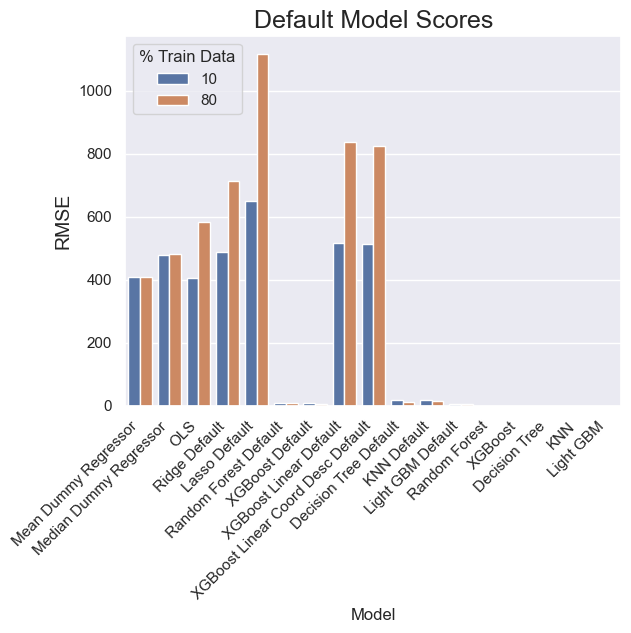

In [156]:
sns.barplot(data=train_scores, x='Model', y='RMSE', hue = '% Train Data')
plt.ylabel('RMSE', fontsize = 14)
plt.xlabel('')
plt.title('Default Model Scores', fontsize = 18)
plt.xticks(rotation=45, ha='right')
plt.savefig('../figures/default_models_80.png',dpi=1200, bbox_inches='tight')
plt.show()

Ok, now that I've got an idea of which models are likely to be the best performers I'll go ahead and do some hyperparameter tuning on the top performers using 10% train data.

In [145]:
parameters = {'max_features': sp_randFloat(0.1, 0.9),
             'max_depth': sp_randInt(3,8),
             'min_samples_leaf': sp_randInt(200,800),
             'n_estimators': sp_randInt(500,1000)
             }
forest = RandomForestRegressor(n_jobs=-1, random_state=15)
forest_reg = RandomizedSearchCV(forest, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
rand_forest = forest_reg.fit(X_tr, y_tr)
rand_forest.best_params_

{'max_depth': 4,
 'max_features': 0.7479325890583333,
 'min_samples_leaf': 223,
 'n_estimators': 916}

In [146]:
opt_forest = RandomForestRegressor(n_estimators=rand_forest.best_params_['n_estimators'],\
                                   max_features=rand_forest.best_params_['max_features'],\
                                   min_samples_leaf=rand_forest.best_params_['min_samples_leaf'],\
                                   max_depth=rand_forest.best_params_['max_depth'], n_jobs = -1, random_state=15)
opt_forest.fit(X_tr, y_tr)
y_pred = opt_forest.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 3, 'Model' : 'Random Forest', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

19.10849277587347

In [147]:
xgb = XGBRegressor()
parameters = {'n_estimators': sp_randInt(500,1000),
             'max_depth': sp_randInt(2,9),
             'eta': sp_randFloat(0.0001,0.99),
             'colsample_bytree': sp_randFloat(0.01,0.99)} 
rand_xgb = RandomizedSearchCV(xgb, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
xgbooster = rand_xgb.fit(X_tr, y_tr)
xgbooster.best_params_

{'colsample_bytree': 0.8251957339723341,
 'eta': 0.25666285593588023,
 'max_depth': 3,
 'n_estimators': 732}

In [148]:
xgb_model = XGBRegressor(n_estimators=xgbooster.best_params_['n_estimators'],\
                                   eta=xgbooster.best_params_['eta'],\
                                   colsample_bytree=xgbooster.best_params_['colsample_bytree'],\
                                   max_depth=xgbooster.best_params_['max_depth'])
xgb_model.fit(X_tr, y_tr)
y_pred = xgb_model.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 3, 'Model' : 'XGBoost', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

7.1747066298110775

In [149]:
d_tree = tree.DecisionTreeRegressor(random_state = 12)
parameters = {'max_depth': sp_randInt(2,8),
             'min_samples_leaf': sp_randInt(100,5000)}
rand_tree = RandomizedSearchCV(d_tree, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
decision_tree = rand_tree.fit(X_tr, y_tr)
decision_tree.best_params_

{'max_depth': 4, 'min_samples_leaf': 243}

In [150]:
decision_tree_model = tree.DecisionTreeRegressor(max_depth = decision_tree.best_params_['max_depth'],\
                                            min_samples_leaf = decision_tree.best_params_['min_samples_leaf'],\
                                            random_state = 15)
decision_tree_model.fit(X_tr, y_tr)
y_pred = decision_tree_model.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 3, 'Model' : 'Decision Tree', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

21.732859422432114

In [151]:
neighbors = KNeighborsRegressor()
parameters = {'n_neighbors': sp_randInt(10,100)}
rand_knn = RandomizedSearchCV(neighbors, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
opt_nn = rand_knn.fit(X_tr, y_tr)
opt_nn.best_params_

{'n_neighbors': 10}

In [152]:
knn_opt = KNeighborsRegressor(n_neighbors = opt_nn.best_params_['n_neighbors'])
knn_opt.fit(X_tr, y_tr)
y_pred = knn_opt.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 3, 'Model' : 'KNN', '% Train Data' : 10, 'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

19.799593691766823

In [168]:
lgbm = lgb.LGBMRegressor(objective = 'regression', metric = 'rmse')
parameters = {'num_leaves': sp_randInt(10,1000),
              'n_estimators': sp_randInt(10,1000),
              'max_depth': sp_randInt(2,10),
              'learning_rate': sp_randFloat(0.001,1)}
rand_lgbm = RandomizedSearchCV(lgbm, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
opt_lgbm = rand_lgbm.fit(X_tr, y_tr)
opt_lgbm.best_params_

{'learning_rate': 0.08840125949289224,
 'max_depth': 7,
 'n_estimators': 976,
 'num_leaves': 563}

In [169]:
lgbm_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'rmse', num_leaves = opt_lgbm.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = opt_lgbm.best_params_['learning_rate'])
lgbm_opt.fit(X_tr, y_tr)
y_pred = lgbm_opt.predict(X_te)
new_row = pd.DataFrame([{'Iteration' : 3, 'Model' : 'Light GBM', '% Train Data' : 10,\
                         'RMSE' : mean_squared_error(y_te, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te, y_pred)

6.7780306317199015

In [170]:
tuned = train_scores[train_scores['Model'].isin(['Light GBM', 'XGBoost', 'Random Forest', 'KNN'])]

In [171]:
tuned

,Model,% Train Data,RMSE,MSE
0,Random Forest,10,NaN,19.108493
0,XGBoost,10,NaN,7.174707
0,KNN,10,NaN,19.799594
0,Light GBM,10,NaN,6.778031
0,XGBoost,80,4.788303,NaN
0,Light GBM,80,3.956026,NaN
0,Light GBM,10,6.778031,NaN


C:\Users\zbro1\anaconda\envs\MOF\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


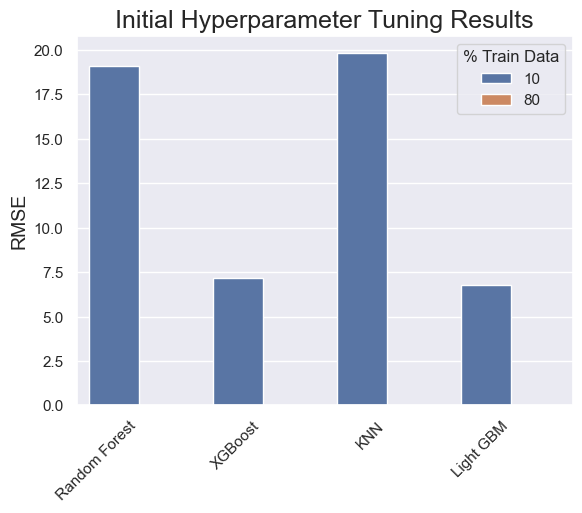

In [172]:
sns.barplot(data=tuned, x='Model', y='MSE', hue = '% Train Data')
plt.ylabel('RMSE', fontsize = 14)
plt.title('Initial Hyperparameter Tuning Results', fontsize = 18)
plt.xticks(rotation=45, ha='right')
plt.xlabel('')
plt.savefig('../figures/init_hyper_tune.png',dpi=1200, bbox_inches='tight')
plt.show()

Ok, so I'm getting about 3x better results with XGBoost and Light GBM, but they're both pretty close to each other, so I'll train those models on 80% of the data and see how they compare so that I can further refine their hyperparameters.

In [162]:
xgb_model.fit(X_tr8, y_tr8)
y_pred = xgb_model.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 4, 'Model' : 'XGBoost', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

4.788302610344

In [173]:
lgbm_opt.fit(X_tr8, y_tr8)
y_pred = lgbm_opt.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 4, 'Model' : 'Light GBM', '% Train Data' : 80,\
                         'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

3.9560259136151847

Great, they're both performing quite well, but I want to tune just one model, so I'll stick with Light GBM from here on since it has consistently beaten XGBoost by a little bit. I'll check the hyperparameter tuning results from earlier to get a feel for whether I can further improve it.

In [174]:
lgbm_results = pd.DataFrame(opt_lgbm.cv_results_)
lgbm_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_learning_rate', 'param_max_depth', 'param_n_estimators',
       'param_num_leaves', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

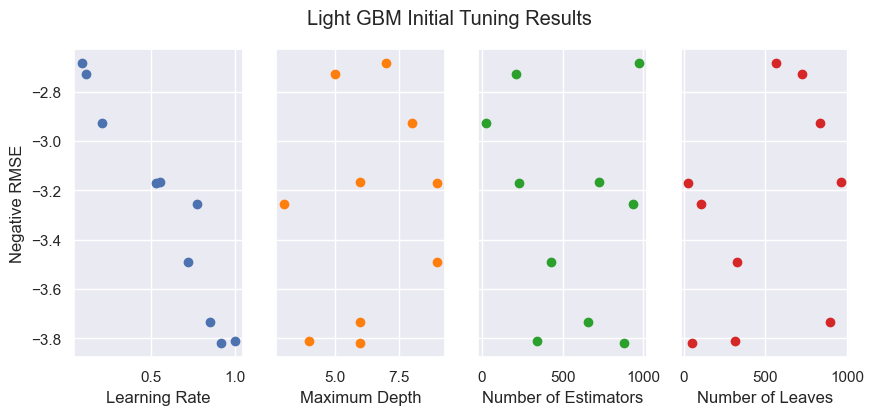

In [175]:
fig, axs = plt.subplots(1, 4, sharey=True)
axs[0].plot(lgbm_results['param_learning_rate'], lgbm_results['mean_test_score'], ls='', marker='o')
axs[1].plot(lgbm_results['param_max_depth'], lgbm_results['mean_test_score'], 'tab:orange', ls='', marker='o')
axs[2].plot(lgbm_results['param_n_estimators'], lgbm_results['mean_test_score'], 'tab:green', ls='', marker='o')
axs[3].plot(lgbm_results['param_num_leaves'], lgbm_results['mean_test_score'], 'tab:red', ls='', marker='o')
axs[0].set_ylabel('Negative RMSE')
axs[0].set_xlabel('Learning Rate')
axs[1].set_xlabel('Maximum Depth')
axs[2].set_xlabel('Number of Estimators')
axs[3].set_xlabel('Number of Leaves')
fig.suptitle('Light GBM Initial Tuning Results')

fig.set_size_inches(10, 4)
plt.savefig('../figures/lgbm_init_tuning.png', dpi=1200, bbox_inches='tight')
plt.show()

Interesting! Based on this it looks like max depth and number of estimators really aren't having much impact, but it does look like I should focus on smaller learning rates and numbers of leaves around 500-800. I'll tune those using this larger training set.

In [180]:
lgb2 = lgb.LGBMRegressor(objective = 'regression', metric = 'rmse', n_estimators = opt_lgbm.best_params_['n_estimators'],
              max_depth = opt_lgbm.best_params_['max_depth'])
parameters = {'num_leaves': sp_randInt(450,800),              
              'learning_rate': sp_randFloat(0.00001,0.1)}
rlgb2 = RandomizedSearchCV(lgb2, parameters, scoring='neg_root_mean_squared_error',\
                                refit='neg_root_mean_squared_error', n_iter=10, cv=5, random_state=15)
olgb2 = rlgb2.fit(X_tr8, y_tr8)
olgb2.best_params_

{'learning_rate': 0.08071794822453758, 'num_leaves': 607}

In [181]:
lgb2_opt = lgb.LGBMRegressor(objective = 'regression', metric = 'rmse', num_leaves = olgb2.best_params_['num_leaves'],\
                             n_estimators = opt_lgbm.best_params_['n_estimators'],\
                             max_depth = opt_lgbm.best_params_['max_depth'],\
                             learning_rate = olgb2.best_params_['learning_rate'])
lgb2_opt.fit(X_tr8, y_tr8)
y_pred = lgb2_opt.predict(X_te8)
new_row = pd.DataFrame([{'Iteration' : 5, 'Model' : 'Light GBM', '% Train Data' : 80, 'RMSE' : mean_squared_error(y_te8, y_pred)}])
train_scores = pd.concat([train_scores, new_row])
mean_squared_error(y_te8, y_pred)

3.9515000761194785

Ok, so I only improved from 3.9560 to 3.9515, which means I've probably optimized this model about as far as I possibly can. Let's plot the progression of the Light GBM models from my initial evaluation up to now.

In [182]:
lgbm_scores = train_scores[train_scores['Model'].isin(['Light GBM', 'Light GBM Default'])]

In [ ]:
plt.plot(lgbm_scores['Iteration'], lgbm_scores['RMSE'], ls='-', marker='o')
plt.xlabel('Model Iterations', fontsize = 14)
plt.ylabel('RMSE', fontsize = 14)
plt.title('Light GBM Model Improvement', fontsize = 18)
plt.savefig('../figures/lgbm_improvement.png', dpi=1200, bbox_inches='tight')
plt.show()

Now I need to check the feature importances for this model to identify exactly which features help the most in predicting the volumetric CO2 working capacity of a MOF.

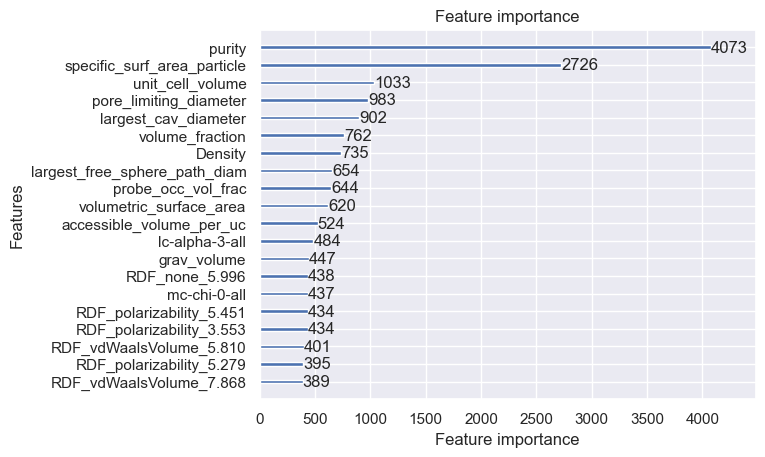

In [189]:
lgb.plot_importance(lgb2_opt, title = 'Light GBM Feature Importances', xlabel = 'Importance Score', max_num_features = 20)
plt.savefig('../figures/feat_importances.png', dpi=1200, bbox_inches='tight')
plt.show()